In [93]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
path = !pwd
from tqdm.notebook import tqdm

In [130]:
# select the pathes for each of the datapoint
path_of_iv = path[0] + "/IV_analysis"
path_iv40 = path[0] +"/IV40"
path_cclamp = path[0] + "/Cclamp"
path_inactivation = path[0] + "/Analysis-Inactivation"
path_rheo = path[0] + "/Rheobase"
path_rheo_trace = path[0] + "/Rheobase_2x_traces"

#get the files in the folders
list_IV = os.listdir(path_of_iv)
list_IV40 = os.listdir(path_iv40)
list_cclamp = os.listdir(path_cclamp)
list_inactivation = os.listdir(path_inactivation)
list_rheo_trace = os.listdir(path_rheo_trace)

#import your metadata
metadata = pd.read_csv("patch_clamp_metadata.csv", delimiter = "\t")
metadata40 = pd.read_csv("patch_clamp_metadata_iv40.csv",delimiter = "\t")
metadata_in = pd.read_csv("inactivation_meta.csv")
meta_clamp = pd.read_csv("metaclamp.csv")
metadata

,data,group,cellline
0,201221_01,ctrl,AD3
1,201221_02,ctrl,AD3
2,201221_03,ctrl,AD3
3,201221_04,ctrl,AD3
4,201221_05,ctrl,AD3
5,201221_06,ngf,AD3
6,201221_07,ngf,AD3
7,201221_10,gdnf,AD3
8,201221_11,gdnf,AD3
9,201221_12,gdnf,AD3


In [80]:
class patch_structure():
    """ Integrated and analysis patch data derived from HEKA as ASCII files
    First started for voltage clamp analysis"""
    
    def __init__(self, path, data, metadatas):
        """ initialize the datastructure
        using the path and the data_index list
        
        path -> path of data
        data -> list of data
        metadata -> metadata integration with description of samples
        datalist -> 
        normalized_data ->
        traces -> IV traces
        group_dictionary -> integrate MetaData
        voltage_traces ->  
        resting_table ->
        """
        self.path = path
        self.data = data
        self.metadata = metadatas
        self.datalist = []
        self.normalized_data = []
        self.traces = []
        self.group_dictionary = None
        self.voltage_traces = None
        self.resting_table = None
        
             
    def initialize(self,index, skiprows):
        """ initalizes the datastructure """
        for i in self.data:
            df = pd.read_csv(self.path + "/" + str(i), skiprows = skiprows)
            columns = [i.replace('"', "") for i in df.columns]
            columns = [i.replace(" ","") for i in columns]
            columns = [name[0:-3] for name in columns]
            df.columns = columns
            df = df.set_index(index)
            self.datalist.append(df)
        
    def normalize(self, rows, normalizer):
        """decide which row should be normalized by which other rows depending on the datastructure
        rows should be added as list"""
        for i in self.datalist:
            i[rows] = i[rows].div(i[normalizer], axis = 0)
            self.normalized_data.append(i)
            
    def IV_trace(self):
        """ get the traces for the Sustained and Peak currents """
        peak_traces = {}
        sustained_traces ={}
        maxed_traces = {}
        end_max = {}
        cslow = {}
        columns = [i[:-4] for i in self.data]
        for i,t in zip(self.normalized_data, columns):
            #get the Columns of choice
            sus = {t: i["Isus"]}
            peak = {t: i["Ipeak"]}
            maximum = {t:i["Imax"]}
            max_end = {t:i["Imax"]}
            cslowed = {t: i["Cslow"]}
            
            #update the dictionary with this columns
            peak_traces.update(peak)
            sustained_traces.update(sus)
            maxed_traces.update(maximum)
            end_max.update(max_end)
            cslow.update(cslowed)

        #get the dataframes for each of the corresponding datasets
        peaks = pd.DataFrame(peak_traces)
        susts = pd.DataFrame(sustained_traces)
        maxs = pd.DataFrame(maxed_traces)
        ending = pd.DataFrame(end_max)
        cslow_df = pd.DataFrame(cslow)
        
        self.voltage_traces = [peaks,susts,maxs,ending, cslow_df]
        
    def integrate_metadata(self, data_row, group_row):
        """drawing mean traces based on metadata
        input --> 
        output --> """
        
        #get the column name of the three groups
        groups = self.metadata["group"].unique()
        
        self.group_dictionary = {}
        
        for i in groups:
            treatment_group = self.metadata[self.metadata[group_row] == i][data_row].tolist()
            meta = {str(i):treatment_group}
            self.group_dictionary.update(meta) # metadata integration stored in the object
            print("group: " + i + " number of samples: " + str(len(treatment_group)))
    
    def draw_traces(self,current, title):
        
        """draw the traces for the data"""
        current_data = self.voltage_traces[current]
        current_dataframe = pd.DataFrame()
        fig,ax = plt.subplots()
        for key,value in self.group_dictionary.items():
            print(key)
            currents = current_data[value].mean(axis = 1)
            sem_current = current_data[value].sem(axis = 1)
            current_dataframe[key] = currents
            current_dataframe[key +"_sem"] = sem_current
            #sns.despine()
            sns.lineplot(x = current_dataframe.index, y = key, data = current_dataframe, color = "blue")
            plt.errorbar(current_dataframe.index, current_dataframe[key], yerr=current_dataframe[key + "_sem"], fmt='-o')
            plt.ylabel("normalized current")
            plt.xlabel("voltage-steps") 
            plt.title(title)
        
    def draw_cslow(self,current):
        """ draw an cslow overview
        """
        current_data = self.voltage_traces[current]
        current_dataframe = pd.DataFrame()
        for key,value in self.group_dictionary.items():
            currents = current_data[value].mean(axis = 1)
            sem_current = current_data[value].sem(axis = 1)
            current_dataframe[key] = currents
            current_dataframe[key +"_sem"] = sem_current
        
        mean_dataframe = pd.DataFrame(current_dataframe[["ctrl","ngf","gdnf"]].mean(axis = 0))
        sem_dataframe = pd.DataFrame(current_dataframe[["ctrl_sem","ngf_sem","gdnf_sem"]].mean(axis = 0))
        sem_dataframe.columns = ["sem"]
        sem = sem_dataframe["sem"].tolist()
        mean_dataframe["sem"] = sem
        mean_dataframe.columns = ["mean", "sem"]
        print(mean_dataframe)
        mean_dataframe.plot(kind = "bar", y = "mean", yerr = "sem")
        
    def resting_membrane(self):
        data = {"data":[],"mean_1":[],"mean_2":[],"mean_3":[]}
        for i,t in zip(self.data, self.datalist):
            data["data"].append(i)
            data["mean_1"].append(t["Mean-1"].tolist()[0])
            data["mean_2"].append(t["Mean-2"].tolist()[0])
            data["mean_3"].append(t["Mean-3"].tolist()[0])
        self.resting_table = pd.DataFrame(data)
        self.resting_table["data"] = [i[:-4] for i in self.resting_table["data"]]
        key_list = []
        for i in self.resting_table["data"]:
            for key, value in self.group_dictionary.items():
                 if i in value:
                    key_list.append(key)
        self.resting_table["group"] = key_list
        self.resting_table = self.resting_table.drop("data", axis = 1)
    
    def draw_resting_figure(self):
        resting_potential = pd.melt(self.resting_table, "group", var_name = "mean_1")
        fig,ax = plt.subplots()
        sns.despine()
        sns.boxplot(x = "mean_1", hue = "group", y = "value", data = resting_potential, palette = "tab20")
        plt.ylabel("resting-membrane potential in V")
        plt.xlabel("")
        
        

In [151]:
from sklearn.decomposition import PCA
class current(patch_structure):
    
    #def __init__(self):
        #super().__init__()
    
    def traces_input(self, output = None):
        traces = {}
        for i,t in tqdm(zip(self.datalist, self.data)):
            d = {t:i["Vmon"]}
            traces.update(d)
            if output:
                fig, ax = plt.subplots(figsize = (15,5))
                sns.lineplot(x = i.index, y = i["Vmon"], linewidth = 1, color = "green")
                plt.title("Name of Experiment: " + str(t))
                plt.xlabel("Time")
                plt.ylabel("Voltage in V")   
        self.trace_df = pd.DataFrame(traces)
    
    def cluster_traces(self, pca = None, correlation = True):
        if correlation:
            correlation = self.trace_df.corr()
            sns.clustermap(correlation)
        
           
        pca = PCA(n_components = 2)
        pcs = pca.fit_transform(self.trace_df.T)
        Title = pca.explained_variance_ratio_
        pca_df = pd.DataFrame(columns = ["PC1","PC2"],data = pcs)
        print("hallo")
        fig, ax = plt.subplots()
        sns.scatterplot(x = "PC1", y= "PC2", data = pca_df)
        plt.xlabel("PC1" + " (" + str(format(Title[0], '.2f')) + ")")
        plt.ylabel("PC2" + " (" + str(format(Title[1], '.2f')) + ")")
        plt.show()

        

        
        
    

In [152]:
rheo_traces = current(path_rheo_trace,list_rheo_trace,metadata)
rheo_traces.initialize("Time",2)
rheo_traces.traces_input()


hallo


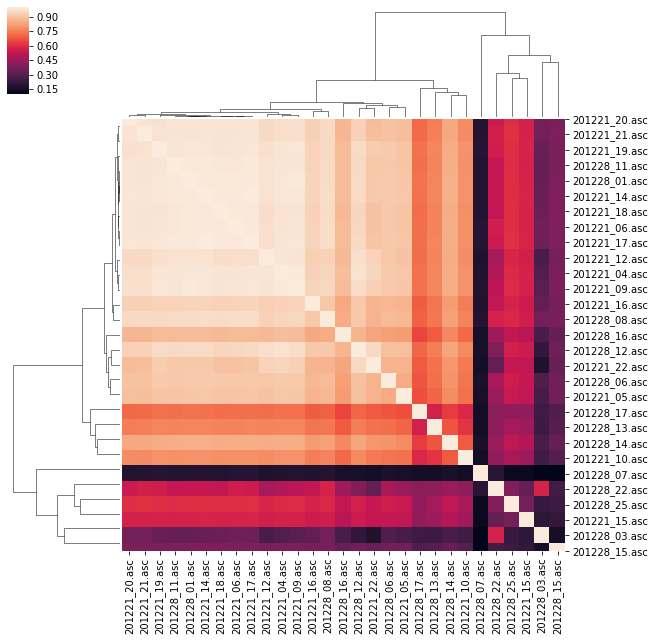

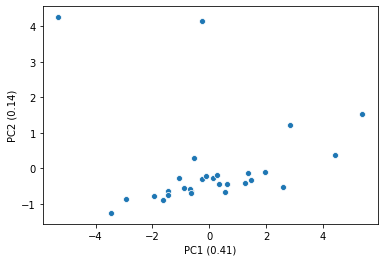

In [153]:
rheo_traces.cluster_traces()

group: ctrl number of samples: 15
group: ngf number of samples: 17
group: gdnf number of samples: 7
ctrl
ngf
gdnf
ctrl
ngf
gdnf
ctrl
ngf
gdnf


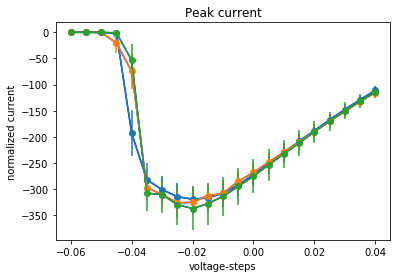

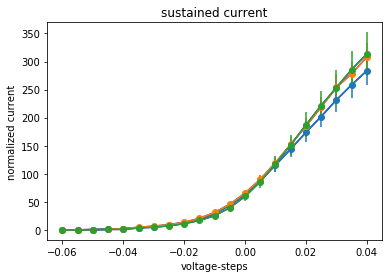

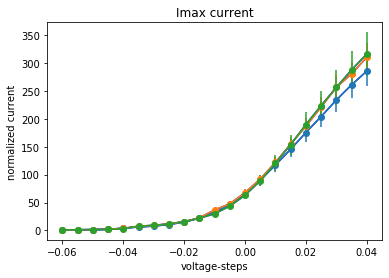

In [20]:
#Analyse the IV
iv_ana = patch_structure(path_of_iv, list_IV, metadata)
iv_ana.initialize("Voltage2")
iv_ana.normalize(["Ipp_bas","Ipp_beg","Ipp_end","Ipeak","Isus","Imax","Max_end"], "Cslow")
iv_ana.IV_trace()
iv_ana.integrate_metadata("data","group")
iv_ana.draw_traces(0,"Peak current")
plt.savefig("peak_current.pdf", quality = 90, transparent = True)
iv_ana.draw_traces(1, "sustained current")
plt.savefig("sustained_current.pdf", quality = 90, transparent = True)
iv_ana.draw_traces(2, "Imax current")
plt.savefig("Imax_current.pdf", quality = 90, transparent = True)

In [ ]:
iv_ana.draw_traces(3, "Max_end current")
iv_ana.draw_cslow(4)"b", var_name="a", value_name="c"

group: ctrl number of samples: 12
group: ngf number of samples: 16
group: gdnf number of samples: 7
ctrl
ngf
gdnf
ctrl
ngf
gdnf
ctrl
ngf
gdnf


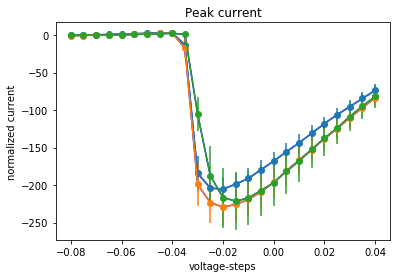

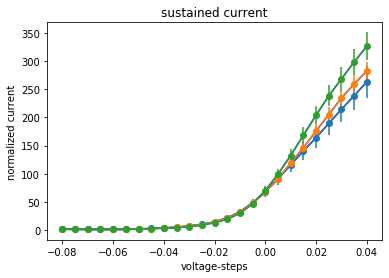

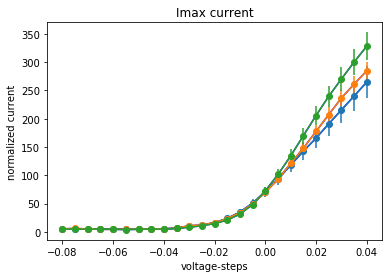

In [21]:
#Analyse the IV-40
iv_40 = patch_structure(path_iv40,list_IV40,metadata40)
iv_40.initialize("Voltage3")
iv_40.normalize(["Ipp_bas","Ipp_beg","Ipp_end","Ipeak","Isus","Imax","Max_end"],"Cslow")
iv_40.IV_trace()
iv_40.integrate_metadata("data","group")
iv_40.draw_traces(0, "Peak current")
plt.savefig("peak_current_40pp.pdf", quality = 90, transparent = True)
iv_40.draw_traces(1, "sustained current")
plt.savefig("sustained_current_40pp.pdf", quality = 90, transparent = True)
iv_40.draw_traces(2, "Imax current")
plt.savefig("Imax_current_40pp.pdf", quality = 90, transparent = True)


In [ ]:
iv_40.draw_traces(3, "End max current")

group: ctrl number of samples: 10
group: ngf number of samples: 12
ctrl
ngf
ctrl
ngf
ctrl
ngf


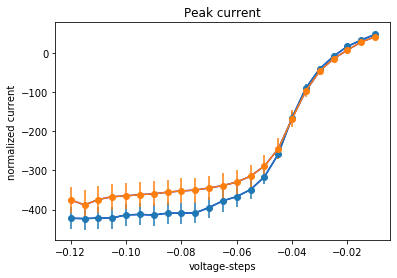

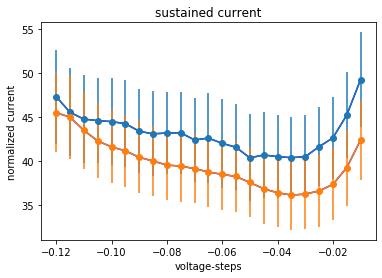

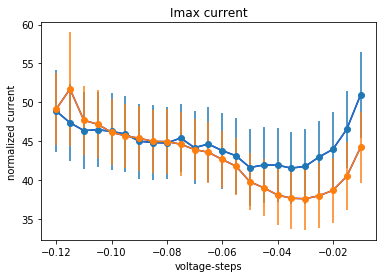

In [22]:
#Analyse the IV-40
in_40 = patch_structure(path_inactivation,list_inactivation,metadata_in)
in_40.initialize("Voltage2")
in_40.normalize(["Ipp_bas","Ipp_end","Ipeak","Isus","Imax","Ipp_end-tr2"],"Cslow")
in_40.IV_trace()
in_40.integrate_metadata("data","group")
in_40.draw_traces(0, "Peak current")
plt.savefig("Inactivation_peak.pdf", quality = 90, transparent = True)
in_40.draw_traces(1, "sustained current")
plt.savefig("Inactivation_sus.pdf", quality = 90, transparent = True)
in_40.draw_traces(2, "Imax current")
plt.savefig("Inactivation_Imax.pdf", quality = 90, transparent = True)


In [ ]:
in_40.draw_traces(3, "Ipp_end-tr2")

group: ctrl number of samples: 11
group: ngf number of samples: 14
group: gdnf number of samples: 9


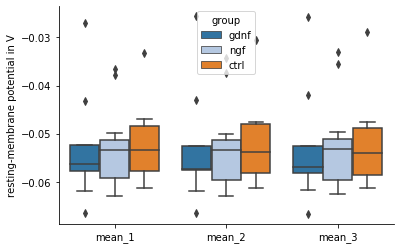

In [23]:
# Calculate the resting membrane potential 
resting = patch_structure(path_cclamp,list_cclamp, meta_clamp)
resting.initialize("Timer")
resting.integrate_metadata("data","group")
resting.resting_membrane()
resting.draw_resting_figure()
plt.savefig("resting_membrane_potential_AD3.pdf", quality = 90, transparent = True)

# Exploratory Data Analysis

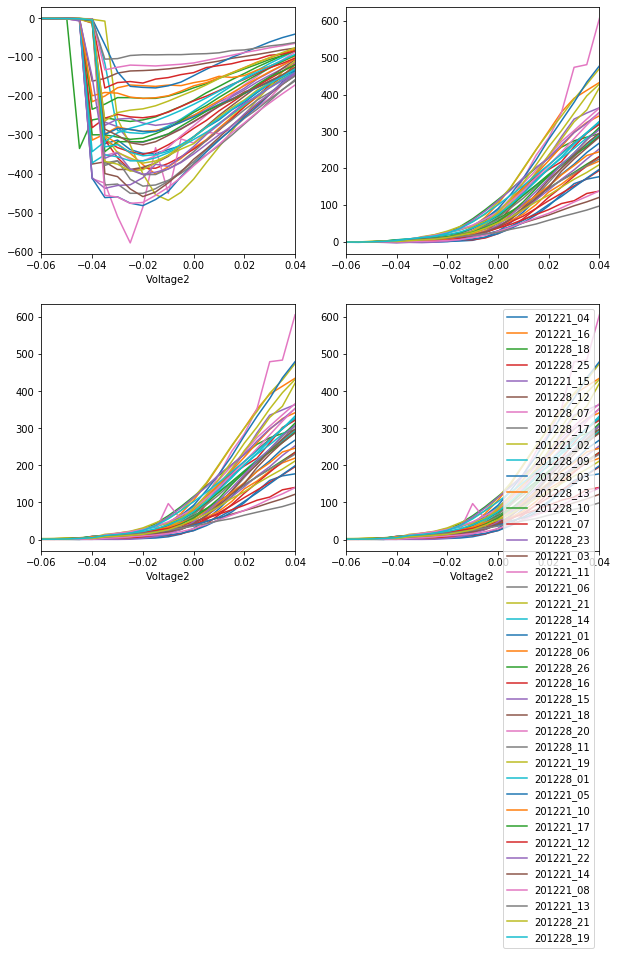

In [26]:
#get an overview about the features that are in the table
fig,ax = plt.subplots(ncols = 2, nrows = 2, figsize = (10,10))
iv_ana.voltage_traces[0].plot(kind = "line", ax = ax[0,0], legend = False)
iv_ana.voltage_traces[1].plot(kind = "line", ax = ax[0,1], legend = False)
iv_ana.voltage_traces[2].plot(kind = "line", ax = ax[1,0], legend = False)
iv_ana.voltage_traces[3].plot(kind = "line", ax = ax[1,1], legend = True)
plt.savefig("all_traces.pdf", quality = 90, transparent = True)